In [1]:
%matplotlib inline


# Imputing missing values before building an estimator


This example shows that imputing the missing values can give better
results than discarding the samples containing any missing value.
Imputing does not always improve the predictions, so please check via
cross-validation.  Sometimes dropping rows or using marker values is
more effective.

Missing values can be replaced by the mean, the median or the most frequent
value using the basic :func:`sklearn.impute.SimpleImputer`.
The median is a more robust estimator for data with high magnitude variables
which could dominate results (otherwise known as a 'long tail').

In addition of using an imputing method, we can also keep an indication of the
missing information using :func:`sklearn.impute.MissingIndicator` which might
carry some information.



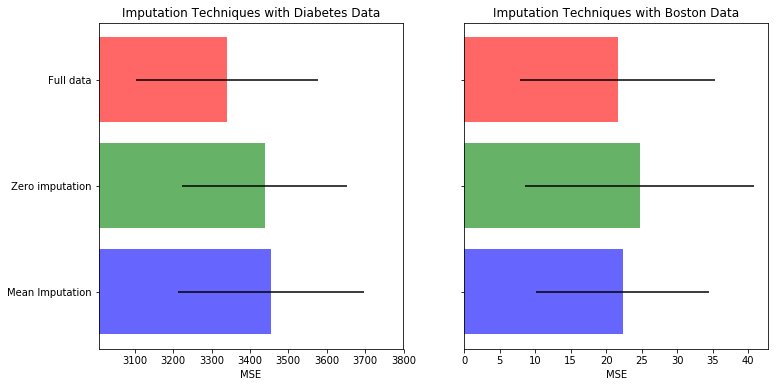

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import cross_val_score

rng = np.random.RandomState(0)


def get_results(dataset):
    X_full, y_full = dataset.data, dataset.target
    n_samples = X_full.shape[0]
    n_features = X_full.shape[1]

    # Estimate the score on the entire dataset, with no missing values
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    full_scores = cross_val_score(estimator, X_full, y_full,
                                  scoring='neg_mean_squared_error', cv=5)

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(np.floor(n_samples * missing_rate))
    missing_samples = np.hstack((np.zeros(n_samples - n_missing_samples,
                                          dtype=np.bool),
                                 np.ones(n_missing_samples,
                                         dtype=np.bool)))
    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)

    # Estimate the score after replacing missing values by 0
    X_missing = X_full.copy()
    X_missing[np.where(missing_samples)[0], missing_features] = 0
    y_missing = y_full.copy()
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    zero_impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                         scoring='neg_mean_squared_error',
                                         cv=5)

    # Estimate the score after imputation (mean strategy) of the missing values
    X_missing = X_full.copy()
    X_missing[np.where(missing_samples)[0], missing_features] = 0
    y_missing = y_full.copy()
    estimator = make_pipeline(
        make_union(SimpleImputer(missing_values=0, strategy="mean"),
                   MissingIndicator(missing_values=0)),
        RandomForestRegressor(random_state=0, n_estimators=100))
    mean_impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                         scoring='neg_mean_squared_error',
                                         cv=5)


    return ((full_scores.mean(), full_scores.std()),
            (zero_impute_scores.mean(), zero_impute_scores.std()),
            (mean_impute_scores.mean(), mean_impute_scores.std()))


results_diabetes = np.array(get_results(load_diabetes()))
mses_diabetes = results_diabetes[:, 0] * -1
stds_diabetes = results_diabetes[:, 1]

results_boston = np.array(get_results(load_boston()))
mses_boston = results_boston[:, 0] * -1
stds_boston = results_boston[:, 1]

n_bars = len(mses_diabetes)
xval = np.arange(n_bars)

x_labels = ['Full data',
            'Zero imputation',
            'Mean Imputation']
colors = ['r', 'g', 'b', 'orange']

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(j, mses_diabetes[j], xerr=stds_diabetes[j],
             color=colors[j], alpha=0.6, align='center')

ax1.set_title('Imputation Techniques with Diabetes Data')
ax1.set_xlim(left=np.min(mses_diabetes) * 0.9,
             right=np.max(mses_diabetes) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel('MSE')
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

# plot boston results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(j, mses_boston[j], xerr=stds_boston[j],
             color=colors[j], alpha=0.6, align='center')

ax2.set_title('Imputation Techniques with Boston Data')
ax2.set_yticks(xval)
ax2.set_xlabel('MSE')
ax2.invert_yaxis()
ax2.set_yticklabels([''] * n_bars)

plt.show()